Result of LTI poles estimation

May 02, 2019 
S.Ukai

* Compare the estimated poles with the true ones
* Check the difference of performance between model001 and model002:
    * model001: x(t+1) = A x(t) + B u(t)
    * model002: x(t+1) = diag(lambda_{i}) x(t) + B u(t), lambda_{i} in $\mathbb{C}$
* Explain the difference by comparing the pair of pole distribution.

In [1]:
import matplotlib.pylab as plt
import pickle
import sqlite3
import os
from modules import *
conn = sqlite3.connect('db.sqlite')
cur = conn.cursor()

# Compare the estimated poles with the true ones:

* model_file_path: in which a model object restores
* lti_file_file: in which a data generator restores

In [2]:
cur.execute('''Select Result.model_file_path, Result.Nhidden, Data.lti_file_path,
    Training.Nepoch, Training.Nhrz
    from Result join Data join Training
    where Result.data_id = Data.id and Result.training_id = Training.id
    and Data.lti_file_path = (?)
    and Training.Nhrz = 16
    and Training.Nepoch = 1024
    ''', ('./tmp/data_012.pk',))
for model_file_path, Nhidden, lti_file_path, _, _ in cur.fetchall():
    if 'model002' in model_file_path:
        break

* A: true system matrix in state space model
* A_hat: estimated one

In [3]:
with open(lti_file_path, "rb") as fp:
    data_generator = pickle.load(fp)
Ny = data_generator.Ny
Nu = data_generator.Nu
A = data_generator.A
eig, _ = np.linalg.eig(A)
if 'model001' in model_file_path:
    mdl = model001(Nhidden, Ny, Nu)
    mdl.load_state_dict(torch.load(model_file_path))

    _weight = mdl.xu2x.weight
    weight = _weight.data.numpy()
    A_hat = weight[:, :Nhidden]
    eig_hat, _ = np.linalg.eig(A_hat)

if 'model002' in model_file_path:
    mdl = model002(Nhidden, Ny, Nu)
    mdl.load_state_dict(torch.load(model_file_path))

    lmbd_real = mdl._lmbd_real.data.numpy()
    lmbd_imag = mdl._lmbd_imag.data.numpy()
    eig_hat = np.concatenate((lmbd_real + 1j * lmbd_imag, lmbd_real - 1j * lmbd_imag))

* See a pair of distibution of eigenvalues of discrete time system:

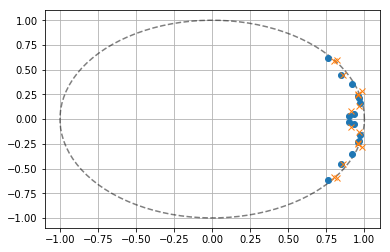

In [4]:
plt.plot(np.cos(2*np.pi*np.linspace(0,1,100)), np.sin(2*np.pi*np.linspace(0,1,100)), '--k', alpha=.5)
plt.plot(np.real(eig), np.imag(eig), 'o')
plt.plot(np.real(eig_hat), np.imag(eig_hat), 'x')
plt.grid()

* See a pair of distibution of eigenvalues of continuous time system:

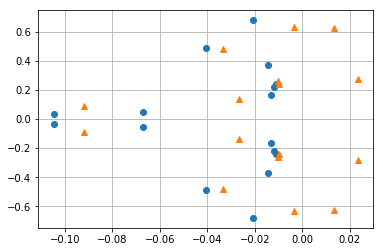

In [5]:
plt.plot(np.real(np.log(eig)), np.imag(np.log(eig)), 'o')
plt.plot(np.real(np.log(eig_hat)), np.imag(np.log(eig_hat)), '^')
plt.grid()

# Check the difference of performance between model001 and model002

* db.sqlite contains the following data
* Trained model (its binary file path)
* Data generator (its binary file path)
* Training parameter
	* Nepoch varies over (2^6, 2^8, 2^10)
	* Nhrz varies over (2^0, 2^2, 2^4)

In [6]:
cur.execute('''Select Result.model_file_path, Result.Nhidden, Data.lti_file_path,
    Training.Nepoch, Training.Nhrz
    from Result join Data join Training
    where Result.data_id = Data.id and Result.training_id = Training.id
    and Data.lti_file_path = (?)
    ''', ('./tmp/data_012.pk',))

tbl = []
model_type = []
for (model_file_path, Nhidden, lti_file_path, Nepoch, Nhrz) in cur.fetchall():
    with open(lti_file_path, "rb") as fp:
        data_generator = pickle.load(fp)
    Ny = data_generator.Ny
    Nu = data_generator.Nu
    A = data_generator.A
    if 'model001' in model_file_path:
        mdl = model001(Nhidden, Ny, Nu)
        mdl.load_state_dict(torch.load(model_file_path))

        _weight = mdl.xu2x.weight
        weight = _weight.data.numpy()
        A_hat = weight[:, :Nhidden]
        eig_hat, _ = np.linalg.eig(A_hat)
        model_type.append('model001')

    if 'model002' in model_file_path:
        mdl = model002(Nhidden, Ny, Nu)
        mdl.load_state_dict(torch.load(model_file_path))

        lmbd_real = mdl._lmbd_real.data.numpy()
        lmbd_imag = mdl._lmbd_imag.data.numpy()
        eig_hat = np.concatenate((lmbd_real + 1j * lmbd_imag, lmbd_real - 1j * lmbd_imag))
        model_type.append('model002')

    M = np.abs(eig_hat.reshape((-1,1)) - eig.reshape((1,-1)))
    wdist, _ = calc_wdist(M)
    tbl.append((Nepoch, Nhrz, wdist))

c:\users\shouta\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\_linprog_util.py:704: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning)
c:\users\shouta\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\_linprog_ip.py:273: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
c:\users\shouta\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\_linprog_ip.py:285: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. I

In [7]:
model_type = np.array(model_type)
tbl = np.array(tbl)

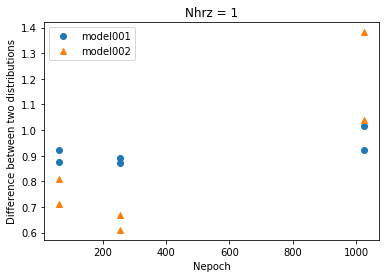

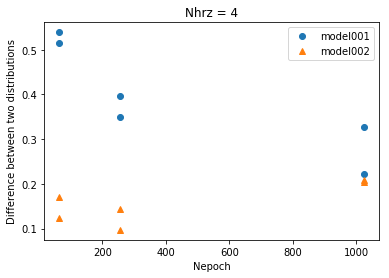

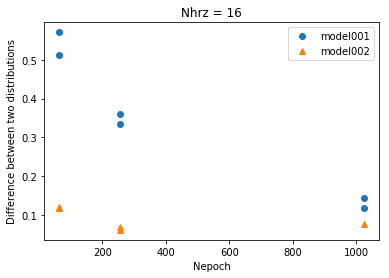

In [8]:
for Nhrz in [2**0, 2**2, 2**4]:
    plt.figure()
    idx = (tbl[:,1] == Nhrz) & (model_type == 'model001')
    plt.plot(tbl[idx,0], tbl[idx,2], 'o', label = 'model001')
    idx = (tbl[:,1] == Nhrz) & (model_type == 'model002')
    plt.plot(tbl[idx,0], tbl[idx,2], '^', label = 'model002')
    plt.legend()
    plt.title('Nhrz = %d' % Nhrz)
    plt.xlabel('Nepoch')
    plt.ylabel('Difference between two distributions')
    plt.yscale('linear')
    plt.show()

* Summary:
    * Pole Estimation accuracy of model002 is much better than the ones of model001.

# Explain the difference by comparing the pair of pole distribution.

* Quantify the difference of the two distributions by using Wasserstein distance:

In [9]:
# a: slave(to be matched), b: master(which is a basis)
def match_eig_dist_to_another(a, b):
    tmp_a = np.array([*map(lambda xx: (np.real(xx), np.imag(xx)), a)]) # (*, 2)
    tmp_b = np.array([*map(lambda xx: (np.real(xx), np.imag(xx)), b)]) # (*, 2)
    c = np.mean(np.abs(1 - tmp_a.reshape((1, -1, 2)) / tmp_b.reshape((-1, 1, 2))), axis=2)
    _, P = calc_wdist(c)
    a_matched = (P @ a)/np.sum(P, axis=1)
    return a_matched

## The best case for model001

In [25]:
cur.execute('''Select Result.model_file_path, Result.Nhidden, Data.lti_file_path,
    Training.Nepoch, Training.Nhrz
    from Result join Data join Training
    where Result.data_id = Data.id and Result.training_id = Training.id
    and Data.lti_file_path = (?)
    and Training.Nhrz = 16
    and Training.Nepoch = 1024
    ''', ('./tmp/data_012.pk',))
for model_file_path, Nhidden, lti_file_path, _, _ in cur.fetchall():
    if 'model002' in model_file_path:
        break

* load model and data generator
* Calculate the estimated (matched) poles and the true one

In [26]:
A = data_generator.A

with open(lti_file_path, "rb") as fp:
    data_generator = pickle.load(fp)
Ny = data_generator.Ny
Nu = data_generator.Nu

mdl = model002(Nhidden, Ny, Nu)
mdl.load_state_dict(torch.load(model_file_path))

lmbd_real = mdl._lmbd_real.data.numpy()
lmbd_imag = mdl._lmbd_imag.data.numpy()
eig_hat = np.concatenate((lmbd_real + 1j * lmbd_imag, lmbd_real - 1j * lmbd_imag))

eig, _= np.linalg.eig(A)

log_eig = np.log(eig)
log_eig_hat = np.log(eig_hat)
log_eig_hat_matched = match_eig_dist_to_another(log_eig_hat, log_eig)

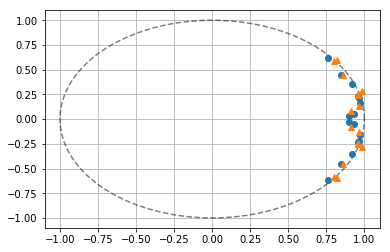

In [27]:
plt.plot(np.cos(2*np.pi*np.linspace(0,1,100)), np.sin(2*np.pi*np.linspace(0,1,100)), '--k', alpha=.5)
plt.plot(eig.real, eig.imag, 'o')
plt.plot(eig_hat.real, eig_hat.imag, '^')
plt.grid()

## The best case for model002

In [19]:
cur.execute('''Select Result.model_file_path, Result.Nhidden, Data.lti_file_path,
    Training.Nepoch, Training.Nhrz
    from Result join Data join Training
    where Result.data_id = Data.id and Result.training_id = Training.id
    and Data.lti_file_path = (?)
    and Training.Nhrz = ?
    and Training.Nepoch = ?
    ''', ('./tmp/data_012.pk', 2**4, 2**10))
model_file_path, Nhidden, lti_file_path, _, _ = cur.fetchone()

* load model and data generator
* Calculate the estimated (matched) poles and the true one

In [20]:
with open(lti_file_path, "rb") as fp:
    data_generator = pickle.load(fp)
Ny = data_generator.Ny
Nu = data_generator.Nu
mdl = model001(Nhidden, Ny, Nu)
mdl.load_state_dict(torch.load(model_file_path))

_weight = mdl.xu2x.weight
weight = _weight.data.numpy()
A_hat = weight[:, :Nhidden]
A = data_generator.A

eig, _= np.linalg.eig(A)
eig_hat, _ = np.linalg.eig(A_hat)

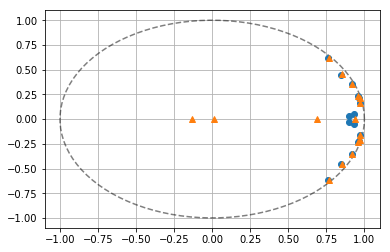

In [21]:
plt.plot(np.cos(2*np.pi*np.linspace(0,1,100)), np.sin(2*np.pi*np.linspace(0,1,100)), '--k', alpha=.5)
plt.plot(eig.real, eig.imag, 'o')
plt.plot(eig_hat.real, eig_hat.imag, '^')
plt.grid()